In [1]:
import sys
sys.path.append(r"/mnt/ceph/users/tudomlumleart/00_VirtualEnvironments/teeu/lib/python3.10/site-packages")
sys.path.append(r"/mnt/home/tudomlumleart/.local/lib/python3.10/site-packages/")
sys.path.append(r"/mnt/home/tudomlumleart/ceph/00_VirtualEnvironments/jupyter-gpu/lib/python3.10/site-packages")
from utils import *
from functions import *
from sklearn.mixture import BayesianGaussianMixture, GaussianMixture 
import sklearn
from sklearn.model_selection import train_test_split 
from sklearn.model_selection import cross_val_score, cross_validate
from sklearn.model_selection import validation_curve

os.environ['TF_ENABLE_ONEDNN_OPTS']='0'

from sklearn.metrics import adjusted_mutual_info_score

import os
import scipy.io

# Load dataset from file
folder_path = '/mnt/home/tudomlumleart/ceph/05_Sox9Dataset/'

# List all .mat files in the folder and load them
cnc_maps = scipy.io.loadmat(folder_path + 'cncMaps.mat')['cncMaps'][:80, :80, :]
esc_maps = scipy.io.loadmat(folder_path + 'escMaps.mat')['escMaps'][:80, :80, :]

# Load polys data and then perform linear interpolation
# List all .mat files in the folder and load them
cnc_polys = scipy.io.loadmat(folder_path + 'cncPols.mat')['cncPols'][:80, :, :]
esc_polys = scipy.io.loadmat(folder_path + 'escPols.mat')['escPols'][:80, :, :]

def interpolate_polymers(polys):
    num_probes, num_coords, num_cells = polys.shape
    new_polys = np.zeros((num_probes, num_coords, num_cells))
    for c in range(num_cells):
        curr_cells = polys[:, :, c]
        for x in range(num_coords):
            curr_coords = curr_cells[:, x]
            missing_indices = np.isnan(curr_coords)
            valid_indices = ~missing_indices
            interp_coords = np.interp(np.flatnonzero(missing_indices), np.flatnonzero(valid_indices), curr_coords[valid_indices])
            new_polys[missing_indices, x, c] = interp_coords
            new_polys[valid_indices, x, c] = curr_coords[valid_indices]
    return new_polys

esc_polys_interp = interpolate_polymers(esc_polys)
cnc_polys_interp = interpolate_polymers(cnc_polys)

esc_maps_interp = np.array([squareform(pdist(esc_polys_interp[:, :, i])) for i in range(esc_polys_interp.shape[2])])
cnc_maps_interp = np.array([squareform(pdist(cnc_polys_interp[:, :, i])) for i in range(cnc_polys_interp.shape[2])])
esc_maps_interp_flat = np.array([x.flatten() for x in esc_maps_interp])
cnc_maps_interp_flat = np.array([x.flatten() for x in cnc_maps_interp])
all_maps_interp_flat = np.concatenate((esc_maps_interp_flat, cnc_maps_interp_flat), axis=0)

from sklearn.decomposition import PCA

pca = PCA(n_components=2)
pca.fit(all_maps_interp_flat)
esc_maps_pca = pca.transform(esc_maps_interp_flat)
cnc_maps_pca = pca.transform(cnc_maps_interp_flat)

# Convert the principal components into a DataFrame
# add a column for the label
esc_df = pd.DataFrame(esc_maps_pca, columns=['PC1', 'PC2'])
esc_df['label'] = 'ESC'
cnc_df = pd.DataFrame(cnc_maps_pca, columns=['PC1', 'PC2'])
cnc_df['label'] = 'CNC'
all_df = pd.concat([esc_df, cnc_df], axis=0)

num_metastructures = 50

# Find 0.05 and 0.95 quantiles of PC1 and PC2 data
pc1_05 = all_df['PC1'].quantile(0.05)
pc1_95 = all_df['PC1'].quantile(0.95)
pc2_05 = all_df['PC2'].quantile(0.05)
pc2_95 = all_df['PC2'].quantile(0.95)

pc1_grid = np.linspace(pc1_05, pc1_95, num_metastructures)
pc2_grid = np.linspace(pc2_05, pc2_95, num_metastructures)

# Generate combination of pc1 and pc2 values
pc1_grid, pc2_grid = np.meshgrid(pc1_grid, pc2_grid)

# Sort PC2 in descending order while keeping PC1 in ascending order


2024-09-05 12:53:06.242259: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-09-05 12:53:06.286785: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX512F AVX512_VNNI, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
# put this into a dataframe
pc1_grid_flat = pc1_grid.flatten()
pc2_grid_flat = pc2_grid.flatten()
pc1_pc2_df = pd.DataFrame({'PC1': pc1_grid_flat, 'PC2': pc2_grid_flat})
pc1_pc2_df['label'] = 'metastructures'
# Sort PC2 in descending order while keeping PC1 in ascending order
pc1_pc2_df = pc1_pc2_df.sort_values(by=['PC1', 'PC2'], ascending=[True, False], ignore_index=True)
metastr_from_pca = pca.inverse_transform(pc1_pc2_df[['PC1', 'PC2']])

In [3]:
save_dir = '/mnt/home/tudomlumleart/ceph/01_ChromatinEnsembleRefinement/chromatin-ensemble-refinement/figures/20240903'

In [4]:
def calculate_variance_sample(dmap_list, dmap_ref, num_probes):
    variance_list = [num_probes**-2 * np.linalg.norm(x - dmap_ref)**2 for x in dmap_list]
    return np.mean(variance_list)

In [5]:
def calculate_variance_sample_no_mean(dmap_list, dmap_ref, num_probes):
    variance_list = [np.sum((x - dmap_ref)**2) for x in dmap_list]
    return np.mean(variance_list)

In [6]:
def calculate_variance_sample_map_no_probe_mean(dmap_list, dmap_ref, num_probes):
    variance_list = [(x - dmap_ref)**2 for x in dmap_list]
    return np.mean(variance_list, axis=0)

In [7]:
esc_median_map = np.median(esc_maps_interp, axis=0)
cnc_median_map = np.median(cnc_maps_interp, axis=0)

In [8]:
esc_variance_map = calculate_variance_sample_map_no_probe_mean(esc_maps_interp, esc_median_map, 80)
cnc_variance_map = calculate_variance_sample_map_no_probe_mean(cnc_maps_interp, cnc_median_map, 80)

In [9]:
esc_variance_list = [(x - esc_median_map)**2 for x in esc_maps_interp] / esc_variance_map
cnc_variance_list = [(x - cnc_median_map)**2 for x in cnc_maps_interp] / cnc_variance_map

/tmp/ipykernel_445598/3419015761.py:1: RuntimeWarning: invalid value encountered in divide
  esc_variance_list = [(x - esc_median_map)**2 for x in esc_maps_interp] / esc_variance_map
/tmp/ipykernel_445598/3419015761.py:2: RuntimeWarning: invalid value encountered in divide
  cnc_variance_list = [(x - cnc_median_map)**2 for x in cnc_maps_interp] / cnc_variance_map


In [10]:
Y_esc = np.array([np.sqrt((x - esc_median_map)**2) for x in esc_maps_interp])
Y_esc_var = np.var(Y_esc, axis=0)

In [25]:
np.mean(Y_esc_var)

36580.613865982545

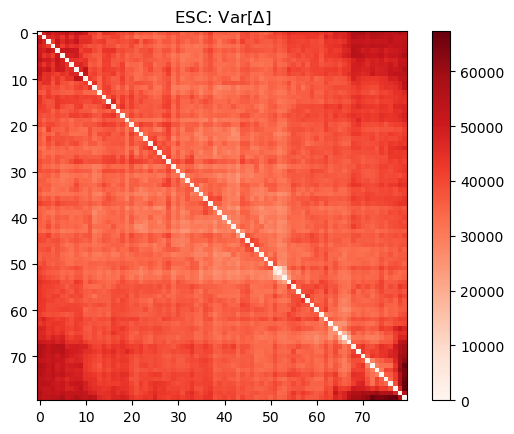

In [11]:
plt.imshow(Y_esc_var, cmap='Reds')
plt.colorbar()
plt.title(r'ESC: $\mathrm{Var}[\Delta]$')
plt.savefig(save_dir + '/ESC_variance_map.png')

In [26]:
np.mean(Y_esc**2)/np.mean(Y_esc_var)

2.392045455132

/tmp/ipykernel_445598/2268780461.py:1: RuntimeWarning: invalid value encountered in divide
  plt.imshow(np.mean(Y_esc**2 / Y_esc_var, axis=0), cmap='Reds')


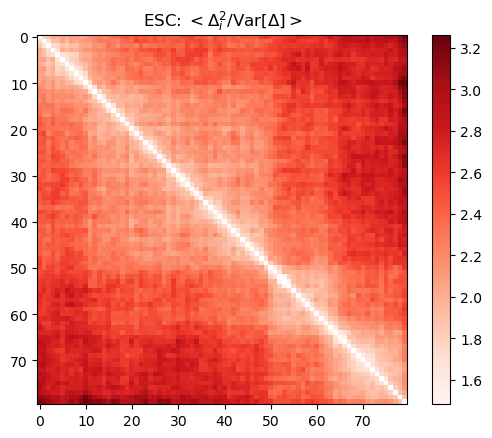

In [12]:
plt.imshow(np.mean(Y_esc**2 / Y_esc_var, axis=0), cmap='Reds')
plt.colorbar()
plt.title(r'ESC: $<\Delta^2_i/\mathrm{Var}[\Delta]>$')
plt.savefig(save_dir + '/ESC_variance_map_ratio.png')

In [13]:
from matplotlib.colors import LogNorm

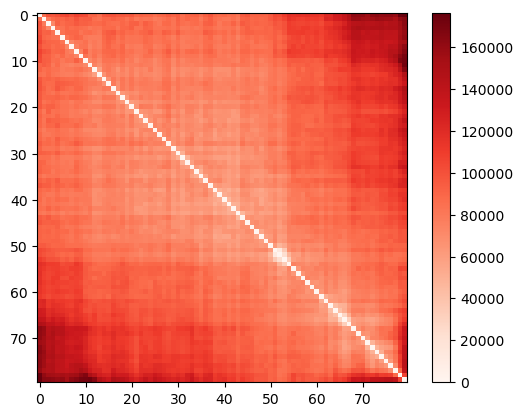

In [14]:
plt.imshow(esc_variance_map, cmap='Reds')
plt.colorbar()

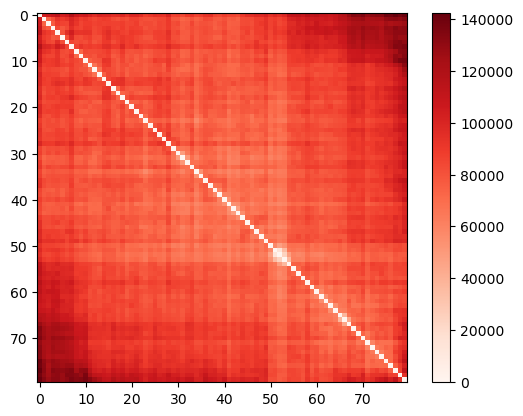

In [15]:
plt.imshow(cnc_variance_map, cmap='Reds')
plt.colorbar()

/tmp/ipykernel_445598/1420756749.py:1: RuntimeWarning: Mean of empty slice
  plt.imshow(np.nanmean(esc_variance_list, axis=0), cmap='Reds')


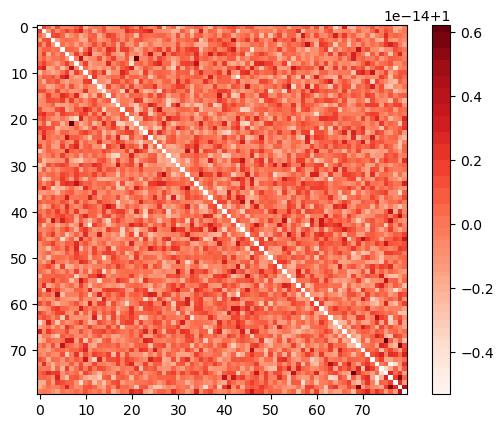

In [16]:
plt.imshow(np.nanmean(esc_variance_list, axis=0), cmap='Reds')
plt.colorbar()

In [17]:
scipy.constants.Boltzmann

1.380649e-23

In [18]:
np.mean(esc_variance_list, axis=0)

array([[nan,  1.,  1., ...,  1.,  1.,  1.],
       [ 1., nan,  1., ...,  1.,  1.,  1.],
       [ 1.,  1., nan, ...,  1.,  1.,  1.],
       ...,
       [ 1.,  1.,  1., ..., nan,  1.,  1.],
       [ 1.,  1.,  1., ...,  1., nan,  1.],
       [ 1.,  1.,  1., ...,  1.,  1., nan]])

In [19]:
# Find the mean of each diagonal then plot
esc_var_dist = [np.mean(np.diag(esc_variance_map, i)) for i in range(0, 81)]
cnc_var_dist = [np.mean(np.diag(cnc_variance_map, i)) for i in range(0, 81)]


/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3432: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/mnt/sw/nix/store/gpkc8q6zjnp3n3h3w9hbmbj6gjbxs85w-python-3.10.10-view/lib/python3.10/site-packages/numpy/core/_methods.py:190: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


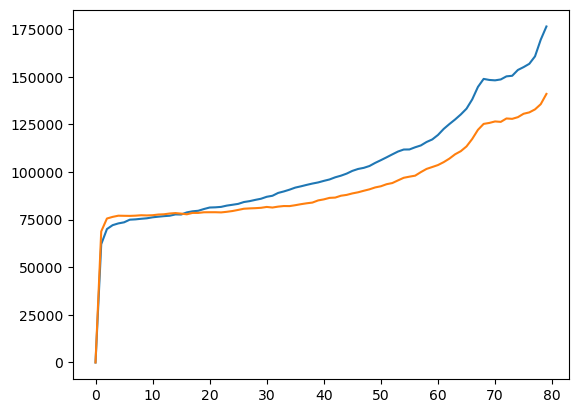

In [20]:
plt.plot(esc_var_dist)
plt.plot(cnc_var_dist)

In [21]:
np.mean(esc_variance_map)

87502.49114406221

In [22]:
esc_variance = calculate_variance_sample_no_mean(esc_maps_interp, esc_median_map, 80)
print(esc_variance)

560015943.3219981


In [23]:
cnc_variance = calculate_variance_sample_no_mean(cnc_maps_interp, cnc_median_map, 80)
print(cnc_variance)

529807407.44420177


In [24]:
esc_variance / (80*80)

87502.49114406221